In [122]:
from collections import Counter
import numpy as np
import torch
import spacy
from sklearn.model_selection import train_test_split

In [123]:
import spacy
from collections import Counter

def prepare_texts(text):    
    # Ensure the text doesn't end with a period immediately followed by a newline
    if text.endswith(".\n"):
        text = text.replace(".\n", ". \n")
    
    # Get a callable object from spaCy that processes the text
    nlp = spacy.load("en_core_web_sm")
    
    # Lemmatize the text, get part of speech, and remove spaces and punctuation
    lemmas = [tok.lemma_ for tok in nlp(text) if tok.pos_ not in ["PUNCT", "SPACE"]]
    
    # Count the number of occurrences of each word in the vocabulary
    freqs = Counter(lemmas)
        
    vocab = list(freqs.items())  # List of (word, occurrence)
    vocab = sorted(vocab, key=lambda item: item[1], reverse=True)  # Sort by decreasing frequency
    
    # Create word->index dictionary and index->word dictionary
    v2i = {v[0]:i for i,v in enumerate(vocab)}
    i2v = {i:v[0] for i,v in enumerate(vocab)}
    
    return lemmas, v2i, i2v, vocab

with open('SmallSimpleCorpus.txt', 'r') as file:
    corpus = file.read()

lemmas, v2i, i2v, vocab = prepare_texts(corpus)

vocab_size = len(v2i)
print("Vocabulary Size:", vocab_size)

most_frequent = list(v2i.keys())[0]
least_frequent = list(v2i.keys())[-1]

print("Most Frequent Word:", most_frequent)
print("Least Frequent Word:", least_frequent)

Vocabulary Size: 11
Most Frequent Word: and
Least Frequent Word: I


#### This following function walks through each word, and looks at a window (of size 'window') of words and creates input/output prediction pairs, predicting each of the words surrounding the current word from the current word.  So here we say that we are 'predicting the context' from the word

In [124]:
def tokenize_and_preprocess_text(textlist, v2i, window):

    X, Y = [], []  # List of training/test samples
    
    # Determine the actual context size from the window.
    context_size = (window - 1) // 2 

    # Iterate over the words in the textlist.
    for i, word in enumerate(textlist):
        
        # Define the start and end index for the context words.
        start_index = max(0, i - context_size)
        end_index = min(len(textlist), i + context_size + 1)
        
        # Iterate over the context words.
        for j in range(start_index, end_index):
            
            # Skip if the context word is the same as the target word.
            if i != j:
                X.append(v2i[word])
                Y.append(v2i[textlist[j]])

    return X, Y

X, Y = tokenize_and_preprocess_text(lemmas, v2i, window=3)
print(X)
print(Y)

[10, 1, 1, 5, 5, 2, 2, 10, 10, 1, 1, 6, 6, 2, 2, 10, 10, 1, 1, 5, 5, 3, 3, 10, 10, 1, 1, 6, 6, 3, 3, 10, 10, 4, 4, 5, 5, 2, 2, 10, 10, 4, 4, 6, 6, 2, 2, 10, 10, 4, 4, 5, 5, 3, 3, 10, 10, 4, 4, 6, 6, 3, 3, 10, 10, 1, 1, 0, 0, 4, 4, 5, 5, 2, 2, 10, 10, 1, 1, 0, 0, 4, 4, 6, 6, 2, 2, 10, 10, 1, 1, 0, 0, 4, 4, 5, 5, 3, 3, 10, 10, 1, 1, 0, 0, 4, 4, 6, 6, 3, 3, 10, 10, 1, 1, 5, 5, 2, 2, 0, 0, 3, 3, 10, 10, 1, 1, 6, 6, 2, 2, 0, 0, 3, 3, 10, 10, 1, 1, 5, 5, 3, 3, 0, 0, 2, 2, 10, 10, 1, 1, 6, 6, 3, 3, 0, 0, 2, 2, 10, 10, 4, 4, 5, 5, 2, 2, 0, 0, 3, 3, 10, 10, 4, 4, 6, 6, 2, 2, 0, 0, 3, 3, 10, 10, 4, 4, 5, 5, 3, 3, 0, 0, 2, 2, 10, 10, 4, 4, 6, 6, 3, 3, 0, 0, 2, 2, 10, 10, 1, 1, 0, 0, 4, 4, 5, 5, 2, 2, 10, 10, 1, 1, 0, 0, 4, 4, 5, 5, 3, 3, 10, 10, 1, 1, 0, 0, 4, 4, 6, 6, 2, 2, 10, 10, 1, 1, 0, 0, 4, 4, 6, 6, 3, 3, 10, 10, 7, 7, 1, 1, 5, 5, 2, 2, 10, 10, 7, 7, 1, 1, 6, 6, 2, 2, 10, 10, 7, 7, 1, 1, 5, 5, 3, 3, 10, 10, 7, 7, 1, 1, 6, 6, 3, 3, 10, 10, 7, 7, 4, 4, 5, 5, 2, 2, 10, 10, 7, 7, 4, 4, 6, 6, 2

## Define Model that will be trained to produce word vectors

In [125]:
import torch.nn as nn

class Word2vecModel(nn.Module):
    def __init__(self, vocab_size, embedding_size=2):
        super(Word2vecModel, self).__init__()

        # Embedding layer: Converts token IDs to vectors
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        # Linear layer: Maps from embedding vectors to vocabulary size (used for prediction)
        self.linear = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, x):
        # Lookup the embedding for the input word indices
        e = self.embedding(x)
        
        # Use the embedding to predict the context word
        logits = self.linear(e)
        
        return logits, e

#### The training function - give it the text and it does the rest

Epoch 1/50, Training Loss: 2.4104, Validation Loss: 2.3670
Epoch 2/50, Training Loss: 2.3602, Validation Loss: 2.3541
Epoch 3/50, Training Loss: 2.3502, Validation Loss: 2.3532
Epoch 4/50, Training Loss: 2.3447, Validation Loss: 2.3427
Epoch 5/50, Training Loss: 2.3390, Validation Loss: 2.3390
Epoch 6/50, Training Loss: 2.3353, Validation Loss: 2.3377
Epoch 7/50, Training Loss: 2.3316, Validation Loss: 2.3349
Epoch 8/50, Training Loss: 2.3302, Validation Loss: 2.3330
Epoch 9/50, Training Loss: 2.3282, Validation Loss: 2.3360
Epoch 10/50, Training Loss: 2.3274, Validation Loss: 2.3318
Epoch 11/50, Training Loss: 2.3275, Validation Loss: 2.3305
Epoch 12/50, Training Loss: 2.3274, Validation Loss: 2.3297
Epoch 13/50, Training Loss: 2.3266, Validation Loss: 2.3333
Epoch 14/50, Training Loss: 2.3274, Validation Loss: 2.3341
Epoch 15/50, Training Loss: 2.3267, Validation Loss: 2.3243
Epoch 16/50, Training Loss: 2.3267, Validation Loss: 2.3345
Epoch 17/50, Training Loss: 2.3267, Validation Lo

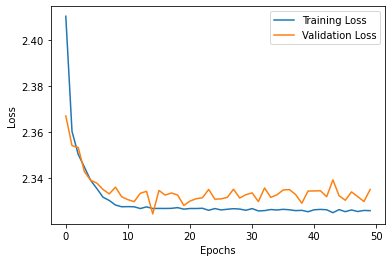

Word2vecModel(
  (embedding): Embedding(11, 2)
  (linear): Linear(in_features=2, out_features=11, bias=True)
)

In [130]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train_word2vec(textlist, window=5, embedding_size=2):
    np.random.seed(43)
    torch.manual_seed(43)
    
    # 1. Create the training data
    X, Y = tokenize_and_preprocess_text(textlist, v2i, window)
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    
    # 2. Split the training data: 80% for training and 20% for validation
    dataset = TensorDataset(X, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    batch_size = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # 3. Instantiate the network
    network = Word2vecModel(vocab_size=len(v2i), embedding_size=embedding_size)
    
    # 4. Set up the optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=0.003)  # You might need to adjust the learning rate

    # Training setup
    epochs = 50
    train_losses = []
    val_losses = []

    # 5. Training loop
    for epoch in range(epochs):
        network.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits, _ = network(x_batch)
            loss = F.cross_entropy(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        
        # Validation loss
        network.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                logits, _ = network(x_batch)
                loss = F.cross_entropy(logits, y_batch)
                total_val_loss += loss.item()
        val_losses.append(total_val_loss / len(val_loader))
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plotting the training and validation curves
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return network

train_word2vec(lemmas, window=5, embedding_size=2)

### Run Training and retrieve embedding

Epoch 1/50, Training Loss: 2.4104, Validation Loss: 2.3670
Epoch 2/50, Training Loss: 2.3602, Validation Loss: 2.3541
Epoch 3/50, Training Loss: 2.3502, Validation Loss: 2.3532
Epoch 4/50, Training Loss: 2.3447, Validation Loss: 2.3427
Epoch 5/50, Training Loss: 2.3390, Validation Loss: 2.3390
Epoch 6/50, Training Loss: 2.3353, Validation Loss: 2.3377
Epoch 7/50, Training Loss: 2.3316, Validation Loss: 2.3349
Epoch 8/50, Training Loss: 2.3302, Validation Loss: 2.3330
Epoch 9/50, Training Loss: 2.3282, Validation Loss: 2.3360
Epoch 10/50, Training Loss: 2.3274, Validation Loss: 2.3318
Epoch 11/50, Training Loss: 2.3275, Validation Loss: 2.3305
Epoch 12/50, Training Loss: 2.3274, Validation Loss: 2.3297
Epoch 13/50, Training Loss: 2.3266, Validation Loss: 2.3333
Epoch 14/50, Training Loss: 2.3274, Validation Loss: 2.3341
Epoch 15/50, Training Loss: 2.3267, Validation Loss: 2.3243
Epoch 16/50, Training Loss: 2.3267, Validation Loss: 2.3345
Epoch 17/50, Training Loss: 2.3267, Validation Lo

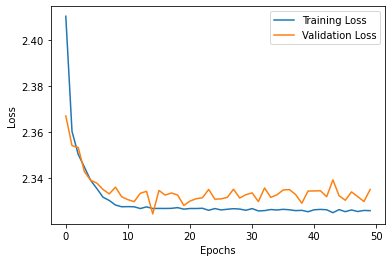

In [132]:
network = train_word2vec(lemmas)
embedding = network.embedding

#### Evaluate some properties of the word embedding

Epoch 1/50, Training Loss: 2.4104, Validation Loss: 2.3670
Epoch 2/50, Training Loss: 2.3602, Validation Loss: 2.3541
Epoch 3/50, Training Loss: 2.3502, Validation Loss: 2.3532
Epoch 4/50, Training Loss: 2.3447, Validation Loss: 2.3427
Epoch 5/50, Training Loss: 2.3390, Validation Loss: 2.3390
Epoch 6/50, Training Loss: 2.3353, Validation Loss: 2.3377
Epoch 7/50, Training Loss: 2.3316, Validation Loss: 2.3349
Epoch 8/50, Training Loss: 2.3302, Validation Loss: 2.3330
Epoch 9/50, Training Loss: 2.3282, Validation Loss: 2.3360
Epoch 10/50, Training Loss: 2.3274, Validation Loss: 2.3318
Epoch 11/50, Training Loss: 2.3275, Validation Loss: 2.3305
Epoch 12/50, Training Loss: 2.3274, Validation Loss: 2.3297
Epoch 13/50, Training Loss: 2.3266, Validation Loss: 2.3333
Epoch 14/50, Training Loss: 2.3274, Validation Loss: 2.3341
Epoch 15/50, Training Loss: 2.3267, Validation Loss: 2.3243
Epoch 16/50, Training Loss: 2.3267, Validation Loss: 2.3345
Epoch 17/50, Training Loss: 2.3267, Validation Lo

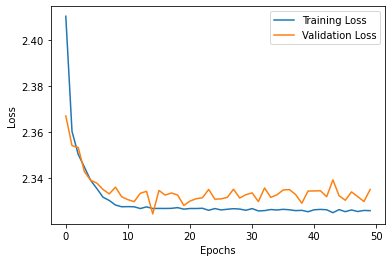

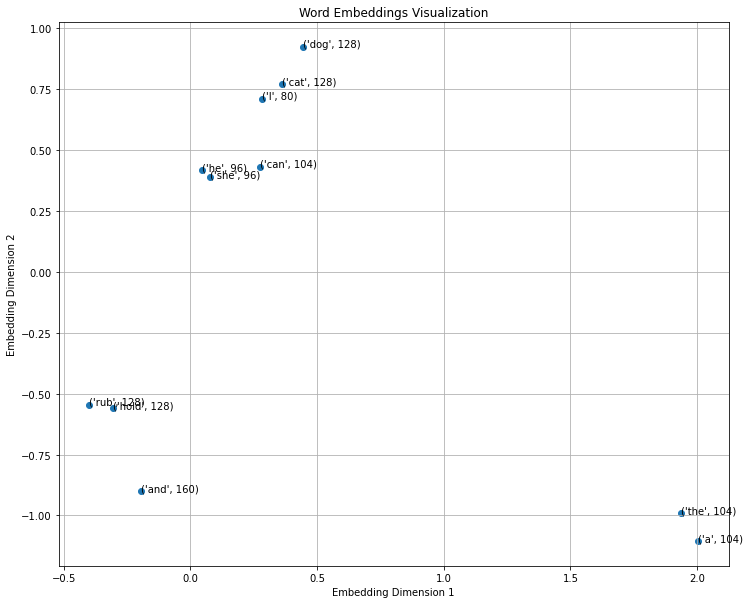

In [131]:
def visualize_embedding(embedding, most_frequent_from=0, most_frequent_to=40):
    assert embedding.shape[1] == 2, "This only supports visualizing 2-d embeddings!"
    
    # TO DO
    # Extract coordinates
    x = embedding[most_frequent_from:most_frequent_to, 0]
    y = embedding[most_frequent_from:most_frequent_to, 1]
    
    # Plot the embeddings
    plt.figure(figsize=(12, 10))
    plt.scatter(x, y, marker='o')
    
    # Annotate each point with its corresponding word
    for i, word in enumerate(vocab[most_frequent_from:most_frequent_to]):
        plt.annotate(word, (x[i], y[i]))
    
    plt.xlabel("Embedding Dimension 1")
    plt.ylabel("Embedding Dimension 2")
    plt.title("Word Embeddings Visualization")
    plt.grid(True)
    plt.show()
    
network = train_word2vec(lemmas)
embedding_weights = network.embedding.weight
visualize_embedding(embedding_weights.detach().numpy(), most_frequent_from=0, most_frequent_to=11)

Epoch 1/50, Training Loss: 2.4104, Validation Loss: 2.3670
Epoch 2/50, Training Loss: 2.3602, Validation Loss: 2.3541
Epoch 3/50, Training Loss: 2.3502, Validation Loss: 2.3532
Epoch 4/50, Training Loss: 2.3447, Validation Loss: 2.3427
Epoch 5/50, Training Loss: 2.3390, Validation Loss: 2.3390
Epoch 6/50, Training Loss: 2.3353, Validation Loss: 2.3377
Epoch 7/50, Training Loss: 2.3316, Validation Loss: 2.3349
Epoch 8/50, Training Loss: 2.3302, Validation Loss: 2.3330
Epoch 9/50, Training Loss: 2.3282, Validation Loss: 2.3360
Epoch 10/50, Training Loss: 2.3274, Validation Loss: 2.3318
Epoch 11/50, Training Loss: 2.3275, Validation Loss: 2.3305
Epoch 12/50, Training Loss: 2.3274, Validation Loss: 2.3297
Epoch 13/50, Training Loss: 2.3266, Validation Loss: 2.3333
Epoch 14/50, Training Loss: 2.3274, Validation Loss: 2.3341
Epoch 15/50, Training Loss: 2.3267, Validation Loss: 2.3243
Epoch 16/50, Training Loss: 2.3267, Validation Loss: 2.3345
Epoch 17/50, Training Loss: 2.3267, Validation Lo

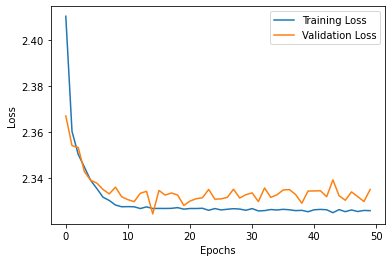

Epoch 1/50, Training Loss: 2.4104, Validation Loss: 2.3670
Epoch 2/50, Training Loss: 2.3602, Validation Loss: 2.3541
Epoch 3/50, Training Loss: 2.3502, Validation Loss: 2.3532
Epoch 4/50, Training Loss: 2.3447, Validation Loss: 2.3427
Epoch 5/50, Training Loss: 2.3390, Validation Loss: 2.3390
Epoch 6/50, Training Loss: 2.3353, Validation Loss: 2.3377
Epoch 7/50, Training Loss: 2.3316, Validation Loss: 2.3349
Epoch 8/50, Training Loss: 2.3302, Validation Loss: 2.3330
Epoch 9/50, Training Loss: 2.3282, Validation Loss: 2.3360
Epoch 10/50, Training Loss: 2.3274, Validation Loss: 2.3318
Epoch 11/50, Training Loss: 2.3275, Validation Loss: 2.3305
Epoch 12/50, Training Loss: 2.3274, Validation Loss: 2.3297
Epoch 13/50, Training Loss: 2.3266, Validation Loss: 2.3333
Epoch 14/50, Training Loss: 2.3274, Validation Loss: 2.3341
Epoch 15/50, Training Loss: 2.3267, Validation Loss: 2.3243
Epoch 16/50, Training Loss: 2.3267, Validation Loss: 2.3345
Epoch 17/50, Training Loss: 2.3267, Validation Lo

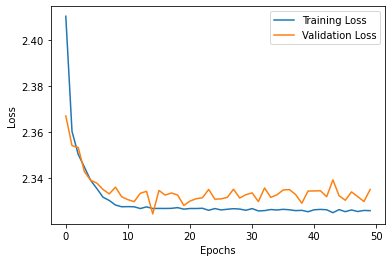

In [134]:
import numpy as np
import torch

np.random.seed(43)
torch.manual_seed(43)

network1 = train_word2vec(lemmas, window=5, embedding_size=2)
network2 = train_word2vec(lemmas, window=5, embedding_size=2)